# Lumped Road Erosion Model Tutorial

In this tutorial, we run a spatially lumped road erosion model with a tri-layered conceptualization (Figure 1) to demonstrate the vertical sediment exchange among layers of a road cross section. The spatially lumped model incorporates two of four traffic-induced, erosion-enhancing processes discussed in Alvis et al. (2023): pumping (Figure 2) and crushing (Figure 3).

<style>
table th, table td {
  width: 33%; /* Adjust the percentage as needed for equal widths */
}
</style>

|<img src="./figs/lumpedModel_noLabels.png" width="600">|<img src="./figs/crushing_threePanel.PNG" width="700">|<img src="./figs/pumping_threePanel.PNG" width="750">|
|:----------------------------------------------:|:---------------------------------------------:|:--------------------------------------------:|
|**Figure 1.** The tri-layered conceptualization that is used to model processes occurring vertically within the road prism.|**Figure 2.** Schematic of the crushing process. On a typical road surface aggregate (left) when traffic is applied (center) the larger sediment breaks down into finer sediment (right). Image not to scale.|**Figure 3.** Schematic of the pumping process. Larger sediment is layered over finer sediment (left) and when traffic is applied (center) the larger sediment gets pushed down which forces the finer sediment upwards (right). Image not to scale.|

The spatially lumped model also incorporates water-driven sediment transport to model the erosion process itself. The domain of the spatially lumped model is a 1-meter by 4.5-meter section within a larger road segment, where every meter-long section is assumed to have the same characteristics such that sediment production in one section can be extrapolated to every other section and summed to obtain the total sediment yield.

|<img src="./figs/modelDomain.png" width="600">|
|:--:|
|**Figure 4.** Schematic of spatially lumped modeling domain within an 80-m by 9-m experimental road segment.|

#### References
Alvis, A. D., Luce, C. H., & Istanbulluoglu, E. (2023). How does traffic 
affect erosion of unpaved forest roads? Environmental Reviews, 31(1), 
182–194. https://doi.org/10.1139/er-2022-0032

## Load necessary `python` packages and read in data

In [1]:
#Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np

#Read in .csv of pre-grouped storms
data_df = pd.read_csv('/home/adalvis/github/roads_lumped_model/'+\
	'rlm_data/dailyStorms_ElkRock10.csv', index_col='date')
data_df.index = pd.to_datetime(data_df.index)

## Do a bit of data wrangling to ensure the data use the correct timestep

In [2]:
# Timestep in hours (each timestep is 24 hours)
timeStep_Hr = data_df.groupby('dates')['dates'].count().to_numpy()
dates = data_df.dates.asfreq('D').to_numpy()
dates_rep = data_df['dates'].copy().to_numpy()
intensity_mmhr = data_df['intensity_mmhr'].copy().to_numpy()
daily_mean = data_df.groupby('dates')['daily_mean'].mean().to_numpy()
daily_depth = data_df.groupby('dates')['daily_depth'].mean().to_numpy()

## Randomly determine the number of trucks per day

Each variable is chosen from a Poisson distribution centered around 5, 10, or 20 trucks per day.

In [3]:
np.random.seed(2) #Use seed to ensure consistent results with each run

truck_pass_5 = np.zeros(len(timeStep_Hr))
truck_pass_10 = np.zeros(len(timeStep_Hr))
truck_pass_20 = np.zeros(len(timeStep_Hr))

for i in range(0, len(timeStep_Hr)):
    truck_pass_5[i] = np.random.poisson(5,1).item()
    truck_pass_10[i]= np.random.poisson(10,1).item()
    truck_pass_20[i] = np.random.poisson(20,1).item()

## Define constants to be used in the model

This includes the very important crushing and pumping constants for the surfacing and the ballast, $k_{cs}$, $k_{cb}$, $u_{ps}$, and $u_{pb}$, which are the main controls on how the layers interact with one another.

In [4]:
# L = representative segment of road, m
# S = m/m
# tau_c = N/m^2
L, rho_w, rho_s, g, S, tau_c, d50, d95 = [4.57, 1000, 2650, 
                                          9.81, 0.05, 0.052,
                                          1.8e-5, 0.02]

# h_s = depth of surfacing
# f_sf, f_sc = fractions of fine/coarse material in ballast
# h_b = depth of surfacing
# f_bf, f_bc = fractions of fine/coarse material in ballast
h_s, f_sf, f_sc = [0.23, 0.275, 0.725]
h_b, f_bf, f_br = [2, 0.20, 0.80]

# k_cs = crushing constant for surfacing, m/truck pass
# k_cb = crushing constant for ballast, m/truck pass
# u_ps = pumping constant for surfacing, m/truck pass
# u_pb = pumping constant for ballast, m/truck pass
k_cs, k_cb, u_ps, u_pb, n_c_5, n_c_10, n_c_20 = [1e-7, 1e-7, 5e-7, 
                                                 1e-7, 0.4, 0.4, 0.4]

## Initialize arrays for each traffic level

In [5]:
#=================for n=5====================
S_f_5, S_s_5, S_sc_5, S_sf_5, S_b_5, S_bc_5, S_bf_5, \
    Hs_out_5, q_ps_5, q_pb_5, q_cs_5, q_cb_5, \
    sed_added_5, sed_cap_5, ref_trans_5 = \
    [np.zeros(len(timeStep_Hr)) for _ in range(15)]

f_s_5, n_f_5, n_t_5, tau_e_5, water_depth_5, tau_5, \
    q_s_5, q_ref_5= \
    [np.zeros(len(intensity_mmhr)) for _ in range(8)]

S_f_5[0] = 0.02
S_s_5[0] = h_s
S_sc_5[0] = h_s*(f_sc)
S_sf_5[0] = h_s*(f_sf)
S_b_5[0] = h_b
S_bc_5[0] = h_b*(f_br)
S_bf_5[0] = h_b*(f_bf)
n_t_5[0] = 0.4

#=================for n=10====================
S_f_10, S_s_10, S_sc_10, S_sf_10, S_b_10, S_bc_10, S_bf_10, \
    Hs_out_10, q_ps_10, q_pb_10, q_cs_10, q_cb_10, \
    sed_added_10, sed_cap_10, ref_trans_10 = \
    [np.zeros(len(timeStep_Hr)) for _ in range(15)]

f_s_10, n_f_10, n_t_10, tau_e_10, water_depth_10, tau_10, \
    q_s_10, q_ref_10 =\
    [np.zeros(len(intensity_mmhr)) for _ in range(8)]

S_f_10[0] = 0.02
S_s_10[0] = h_s
S_sc_10[0] = h_s*(f_sc)
S_sf_10[0] = h_s*(f_sf)
S_b_10[0] = h_b
S_bc_10[0] = h_b*(f_br)
S_bf_10[0] = h_b*(f_bf)
n_t_10[0] = 0.4

#=================for n=20====================
S_f_20, S_s_20, S_sc_20, S_sf_20, S_b_20, S_bc_20, S_bf_20, \
    Hs_out_20, q_ps_20, q_pb_20, q_cs_20, q_cb_20, \
    sed_added_20, sed_cap_20, ref_trans_20 = \
    [np.zeros(len(timeStep_Hr)) for _ in range(15)]

f_s_20, n_f_20, n_t_20, tau_e_20, water_depth_20, tau_20, \
    q_s_20, q_ref_20 = \
    [np.zeros(len(intensity_mmhr)) for _ in range(8)]

S_f_20[0] = 0.02
S_s_20[0] = h_s
S_sc_20[0] = h_s*(f_sc)
S_sf_20[0] = h_s*(f_sf)
S_b_20[0] = h_b
S_bc_20[0] = h_b*(f_br)
S_bf_20[0] = h_b*(f_bf)
n_t_20[0] = 0.4


q = np.zeros(len(intensity_mmhr))
q[0] = intensity_mmhr[0]*2.77778e-7*L

## Run the model!

The model is being forced using 10 years of rainfall data from a gage at Elk Rock near Mount St. Helens in Washington state.

For each of the following traffic levels, the model loop is the same:
* For each timestep (1 day):
    * Update the depths of the layers based on the pumping and crushing fluxes.
    * Update the depth of the TAF layer based on flow:
        * For every day, calculate the average daily flow from the rainfall intensity, the water depth assuming uniform overland flow, the shear stress and effective shear stress, and the sediment transport and reference sediment transport.

### Traffic level: 5 trucks per day

In [6]:
for j, date in enumerate(dates):
    if j == 0:
        continue
    else:
        q_ps_5[j] = u_ps*(S_sf_5[j-1]/S_s_5[j-1])*truck_pass_5[j]
        q_pb_5[j] = u_pb*(S_bf_5[j-1]/S_b_5[j-1])*truck_pass_5[j]
        q_cs_5[j] = k_cs*(S_sc_5[j-1]/S_s_5[j-1])*truck_pass_5[j]
        q_cb_5[j] = k_cb*(S_bc_5[j-1]/S_b_5[j-1])*truck_pass_5[j]
        S_bc_5[j] = S_bc_5[j-1] - q_cb_5[j]
        S_sc_5[j] = S_sc_5[j-1] - q_cs_5[j]
        S_sf_5[j] = S_sf_5[j-1] + q_cs_5[j] - q_ps_5[j] \
            + q_pb_5[j]
        S_bf_5[j] = S_bf_5[j-1] + q_cb_5[j] - q_pb_5[j]
        
        S_s_5[j] = S_sc_5[j] + S_sf_5[j]
        S_b_5[j] = S_bc_5[j] + S_bf_5[j]

        sed_added_5[j] = q_ps_5[j]
        S_f_5[j] = S_f_5[j-1] + sed_added_5[j]
        
#===========================Detemine qs n = 5===========================
    for k, day in enumerate(dates_rep):
        if day == date:
            if k == 0:
                continue
            else:
                # Calculate avg daily flow
                q[k] = intensity_mmhr[k]*2.77778e-7*L 
                            
                if q[k] > 0:
                    #Determine Manning's GRAIN roughness
                    n_f_5[k] = 0.0026*q[k]**(-0.274)#*(S_f_init[k]/d95) #Based on Emmett (1970) Series 8 Lab Data
                    
                    if S_f_5[j] <= d95:
                        #Determine TOTAL Manning's roughness & partitioning ratio
                        n_t_5[k] = n_c_5 + (S_f_5[j]/d95)*(n_f_5[k]-n_c_5)
                        f_s_5[k] = (n_f_5[k]/n_t_5[k])**(1.5)*(S_f_5[j]/d95)
                    else: 
                        n_t_5[k] = n_f_5[k]              
                        f_s_5[k] = (n_f_5[k]/n_t_5[k])**(1.5)                 
                else:
                    n_f_5[k] = n_f_5[k-1]
                    n_t_5[k] = n_t_5[k-1]
                    f_s_5[k] = f_s_5[k-1]

                #Calculate water depth assuming uniform overland flow
                water_depth_5[k] = ((n_t_5[k]*q[k])/(S**(1/2)))**(3/5)

                tau_5[k] = rho_w*g*water_depth_5[k]*S
                tau_e_5[k] = tau_5[k]*f_s_5[k]

                #Calculate sediment transport rate
                if (tau_e_5[k]-tau_c) >= 0:
                    q_s_5[k] = (((10**(-4.348))/(rho_s*((d50)**(0.811))))*(tau_e_5[k]-tau_c)**(2.457))
                else:
                    q_s_5[k] = 0

                #Calculate reference transport 
                if (tau_5[k]-tau_c) >=0:
                    q_ref_5[k] = (((10**(-4.348))/(rho_s*((d50)**(0.811))))*(tau_5[k]-tau_c)**(2.457))
                else:
                    q_ref_5[k] = 0

#===========================END INTEGRATE OVER qs===========================
            
            sed_cap_5[j] += q_s_5[k]*3600/L
            ref_trans_5[j] += q_ref_5[k]*3600/L

    Hs_out_5[j] = np.minimum(sed_added_5[j]+S_f_5[j-1], sed_cap_5[j])
    S_f_5[j] = S_f_5[j-1] + sed_added_5[j] - Hs_out_5[j]

### Traffic level: 10 trucks per day

In [7]:
for j, date in enumerate(dates):
    if j == 0:
        continue
    else:
        q_ps_10[j] = u_ps*(S_sf_10[j-1]/S_s_10[j-1])*truck_pass_10[j]
        q_pb_10[j] = u_pb*(S_bf_10[j-1]/S_b_10[j-1])*truck_pass_10[j]
        q_cs_10[j] = k_cs*(S_sc_10[j-1]/S_s_10[j-1])*truck_pass_10[j]
        q_cb_10[j] = k_cb*(S_bc_10[j-1]/S_b_10[j-1])*truck_pass_10[j]
        S_bc_10[j] = S_bc_10[j-1] - q_cb_10[j]
        S_sc_10[j] = S_sc_10[j-1] - q_cs_10[j]
        S_bf_10[j] = S_bf_10[j-1] + q_cb_10[j] - q_pb_10[j]
        S_sf_10[j] = S_sf_10[j-1] + q_cs_10[j] - q_ps_10[j] \
            + q_pb_10[j]\
        
        S_s_10[j] = S_sc_10[j] + S_sf_10[j]
        S_b_10[j] = S_bc_10[j] + S_bf_10[j]

        sed_added_10[j] = q_ps_10[j]
        S_f_10[j] = S_f_10[j-1] + sed_added_10[j]

#===========================Detemine qs n = 10===========================
    for k, day in enumerate(dates_rep):
        if day == date:
            if k == 0:
                continue
            else:
                # Calculate avg daily flow
                q[k] = intensity_mmhr[k]*2.77778e-7*L 
                            
                if q[k] > 0:
                    #Determine Manning's GRAIN roughness
                    n_f_10[k] = 0.0026*q[k]**(-0.274)#*(S_f_init[k]/d95) #Based on Emmett (1970) Series 8 Lab Data
                    
                    if S_f_10[j] <= d95:
                        #Determine TOTAL Manning's roughness & partitioning ratio
                        n_t_10[k] = n_c_10 + (S_f_10[j]/d95)*(n_f_10[k]-n_c_10)
                        f_s_10[k] = (n_f_10[k]/n_t_10[k])**(1.5)*(S_f_10[j]/d95)
                    else: 
                        n_t_10[k] = n_f_10[k]              
                        f_s_10[k] = (n_f_10[k]/n_t_10[k])**(1.5)                 
                else:
                    n_f_10[k] = n_f_10[k-1]
                    n_t_10[k] = n_t_10[k-1]
                    f_s_10[k] = f_s_10[k-1]

                #Calculate water depth assuming uniform overland flow
                water_depth_10[k] = ((n_t_10[k]*q[k])/(S**(1/2)))**(3/5)

                tau_10[k] = rho_w*g*water_depth_10[k]*S
                tau_e_10[k] = tau_10[k]*f_s_10[k]

                #Calculate sediment transport rate
                if (tau_e_10[k]-tau_c) >= 0:
                    q_s_10[k] = (((10**(-4.348))/(rho_s*((d50)**(0.811))))*(tau_e_10[k]-tau_c)**(2.457))
                else:
                    q_s_10[k] = 0

                #Calculate reference transport 
                if (tau_10[k]-tau_c) >=0:
                    q_ref_10[k] = (((10**(-4.348))/(rho_s*((d50)**(0.811))))*(tau_10[k]-tau_c)**(2.457))
                else:
                    q_ref_10[k] = 0

#===========================END INTEGRATE OVER qs===========================
            
            sed_cap_10[j] += q_s_10[k]*3600/L
            ref_trans_10[j] += q_ref_10[k]*3600/L

    Hs_out_10[j] = np.minimum(sed_added_10[j]+S_f_10[j-1], sed_cap_10[j])
    S_f_10[j] = S_f_10[j-1] + sed_added_10[j] - Hs_out_10[j]

### Traffic level: 20 trucks per day

In [8]:
for j, date in enumerate(dates):
    if j == 0:
        continue
    else:
        q_ps_20[j] = u_ps*(S_sf_20[j-1]/S_s_20[j-1])*truck_pass_20[j]
        q_pb_20[j] = u_pb*(S_bf_20[j-1]/S_b_20[j-1])*truck_pass_20[j]
        q_cs_20[j] = k_cs*(S_sc_20[j-1]/S_s_20[j-1])*truck_pass_20[j]
        q_cb_20[j] = k_cb*(S_bc_20[j-1]/S_b_20[j-1])*truck_pass_20[j]
        S_bc_20[j] = S_bc_20[j-1] - q_cb_20[j]
        S_sc_20[j] = S_sc_20[j-1] - q_cs_20[j]
        S_bf_20[j] = S_bf_20[j-1] + q_cb_20[j] - q_pb_20[j]
        S_sf_20[j] = S_sf_20[j-1] + q_cs_20[j] - q_ps_20[j] \
            + q_pb_20[j]
        
        S_s_20[j] = S_sc_20[j] + S_sf_20[j]
        S_b_20[j] = S_bc_20[j] + S_bf_20[j]

        sed_added_20[j] = q_ps_20[j]
        S_f_20[j] = S_f_20[j-1] + sed_added_20[j]

#===========================Detemine qs n = 20===========================
    for k, day in enumerate(dates_rep):
        if day == date:
            if k == 0:
                continue
            else:
                # Calculate avg daily flow
                q[k] = intensity_mmhr[k]*2.77778e-7*L 
                            
                if q[k] > 0:
                    #Determine Manning's GRAIN roughness
                    n_f_20[k] = 0.0026*q[k]**(-0.274)#*(S_f_init[k]/d95) #Based on Emmett (1970) Series 8 Lab Data
                    
                    if S_f_20[j] <= d95:
                        #Determine TOTAL Manning's roughness & partitioning ratio
                        n_t_20[k] = n_c_20 + (S_f_20[j]/d95)*(n_f_20[k]-n_c_20)
                        f_s_20[k] = (n_f_20[k]/n_t_20[k])**(1.5)*(S_f_20[j]/d95)
                    else: 
                        n_t_20[k] = n_f_20[k]              
                        f_s_20[k] = (n_f_20[k]/n_t_20[k])**(1.5)                 
                else:
                    n_f_20[k] = n_f_20[k-1]
                    n_t_20[k] = n_t_20[k-1]
                    f_s_20[k] = f_s_20[k-1]

                #Calculate water depth assuming uniform overland flow
                water_depth_20[k] = ((n_t_20[k]*q[k])/(S**(1/2)))**(3/5)

                tau_20[k] = rho_w*g*water_depth_20[k]*S
                tau_e_20[k] = tau_20[k]*f_s_20[k]

                #Calculate sediment transport rate
                if (tau_e_20[k]-tau_c) >= 0:
                    q_s_20[k] = (((10**(-4.348))/(rho_s*((d50)**(0.811))))*(tau_e_20[k]-tau_c)**(2.457))
                else:
                    q_s_20[k] = 0

                #Calculate reference transport 
                if (tau_20[k]-tau_c) >=0:
                    q_ref_20[k] = (((10**(-4.348))/(rho_s*((d50)**(0.811))))*(tau_20[k]-tau_c)**(2.457))
                else:
                    q_ref_20[k] = 0

#===========================END INTEGRATE OVER qs===========================
            
            sed_cap_20[j] += q_s_20[k]*3600/L
            ref_trans_20[j] += q_ref_20[k]*3600/L

    Hs_out_20[j] = np.minimum(sed_added_20[j]+S_f_20[j-1], sed_cap_20[j])
    S_f_20[j] = S_f_20[j-1] + sed_added_20[j] - Hs_out_20[j]

## For ease of analysis, add all updated numpy arrays to a Pandas dataframe

In [9]:
storms_df = pd.DataFrame()
storms_df.index=pd.to_datetime(data_df.dates.asfreq('D'))

storms_df['qf1_5'] = q_ps_5
storms_df['qf2_5'] = q_pb_5
storms_df['S_f_5'] = S_f_5*1000
storms_df['S_s_5'] = S_s_5
storms_df['S_sc_5'] = S_sc_5
storms_df['S_sf_5'] = S_sf_5
storms_df['S_b_5'] = S_b_5
storms_df['S_bc_5'] = S_bc_5
storms_df['S_bf_5'] = S_bf_5
storms_df['Hs_out_5'] = Hs_out_5*1000
storms_df['sed_added_5'] = sed_added_5
storms_df['sed_cap_5'] = sed_cap_5*1000
storms_df['ref_trans_5'] = ref_trans_5*1000

storms_df['qf1_10'] = q_ps_10
storms_df['qf2_10'] = q_pb_10
storms_df['S_f_10'] = S_f_10*1000
storms_df['S_s_10'] = S_s_10
storms_df['S_sc_10'] = S_sc_10
storms_df['S_sf_10'] = S_sf_10
storms_df['S_b_10'] = S_b_10
storms_df['S_bc_10'] = S_bc_10
storms_df['S_bf_10'] = S_bf_10
storms_df['Hs_out_10'] = Hs_out_10*1000
storms_df['sed_added_10'] = sed_added_10
storms_df['sed_cap_10'] = sed_cap_10*1000
storms_df['ref_trans_10'] = ref_trans_10*1000

storms_df['qf1_20'] = q_ps_20
storms_df['qf2_20'] = q_pb_20
storms_df['S_f_20'] = S_f_20*1000
storms_df['S_s_20'] = S_s_20
storms_df['S_sc_20'] = S_sc_20
storms_df['S_sf_20'] = S_sf_20
storms_df['S_b_20'] = S_b_20
storms_df['S_bc_20'] = S_bc_20
storms_df['S_bf_20'] = S_bf_20
storms_df['Hs_out_20'] = Hs_out_20*1000
storms_df['sed_added_20'] = sed_added_20
storms_df['sed_cap_20'] = sed_cap_20*1000
storms_df['ref_trans_20'] = ref_trans_20*1000

## Examine the results!

### Sediment transport vs. reference sediment transport

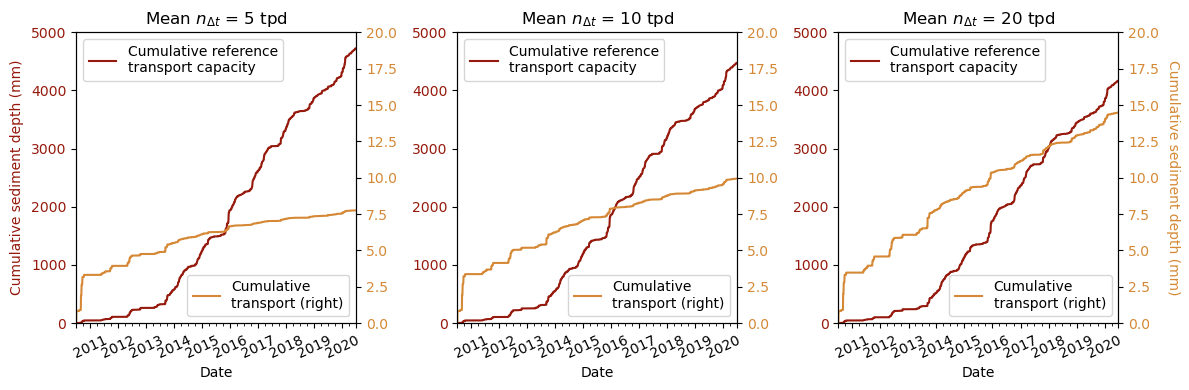

In [10]:
plt.close('all')

fig1, ax1 = plt.subplots(1, 3, figsize=(12,4), layout='tight')
storms_df.ref_trans_5.cumsum().plot(color = '#95190C', label='Cumulative reference\ntransport capacity', ax=ax1[0])
storms_df.ref_trans_10.cumsum().plot(color = '#95190C', label='Cumulative reference\ntransport capacity', ax=ax1[1])
storms_df.ref_trans_20.cumsum().plot(color = '#95190C', label='Cumulative reference\ntransport capacity', ax=ax1[2])
storms_df.Hs_out_5.cumsum().plot(linestyle='-', color='#D58936', label='Cumulative\ntransport', ax=ax1[0], secondary_y=True)
storms_df.Hs_out_10.cumsum().plot(linestyle='-', color='#D58936', label='Cumulative\ntransport', ax=ax1[1], secondary_y=True)
storms_df.Hs_out_20.cumsum().plot(linestyle='-', color='#D58936', label='Cumulative\ntransport', ax=ax1[2], secondary_y=True)

for ax in ax1.flatten():
    ax.legend(loc="upper left")
    ax.right_ax.legend(loc="lower right")
    for label in ax.get_xticklabels():
        label.set_horizontalalignment('center')
    ax.set(xlabel='Date', ylim=(0,5000))
    ax.tick_params(axis='x', labelrotation=25)
    ax.right_ax.set_ylim(0,20)
    for tl in ax.get_yticklabels():
        tl.set_color('#95190C') 
    for tl in ax.right_ax.get_yticklabels():
        tl.set_color('#D58936') 

ax1[0].set_title(r'Mean $n_{\Delta t}$ = 5 tpd')
ax1[1].set_title(r'Mean $n_{\Delta t}$ = 10 tpd')
ax1[2].set_title(r'Mean $n_{\Delta t}$ = 20 tpd')
ax1[0].set_ylabel('Cumulative sediment depth (mm)', labelpad=5, color='#95190C')
ax1[2].right_ax.set_ylabel('Cumulative sediment depth (mm)', rotation=270, labelpad=15, color='#D58936')

plt.tight_layout()
plt.show()

### Fine sediment storage over time

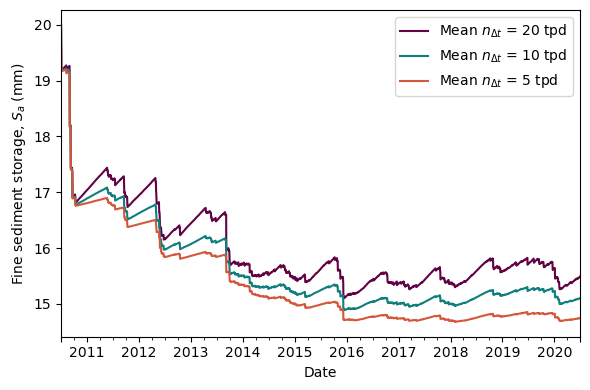

In [11]:
fig2, ax2 = plt.subplots(figsize=(6,4))
storms_df.plot(y='S_f_20', ax=ax2, color = '#610345', label=r'Mean $n_{\Delta t}$ = 20 tpd')
storms_df.plot(y='S_f_10', ax=ax2, color = '#107E7D', label=r'Mean $n_{\Delta t}$ = 10 tpd')
storms_df.plot(y='S_f_5', ax=ax2, color = '#D5573B', label=r'Mean $n_{\Delta t}$ = 5 tpd')
plt.xlabel('Date')
plt.ylabel('Fine sediment storage, $S_a$ (mm)')
ax2.legend(loc="upper right")
# ax2.set_ylim(18,21.5)
for label in ax2.get_xticklabels():
    label.set_horizontalalignment('center')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


### Surfacing storage over time

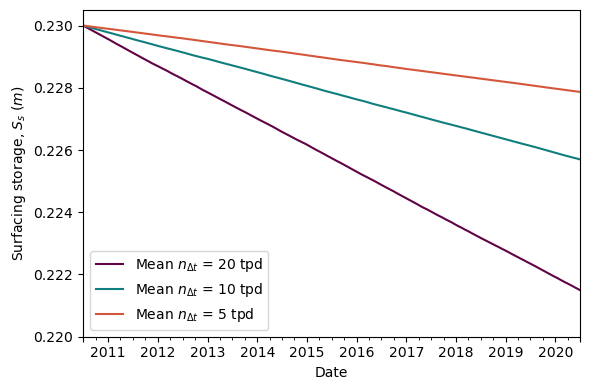

In [12]:
fig4, ax4 = plt.subplots(figsize=(6,4))
storms_df.plot(y='S_s_20', ax=ax4, color = '#610345', label=r'Mean $n_{\Delta t}$ = 20 tpd')
storms_df.plot(y='S_s_10', ax=ax4, color = '#107E7D', label=r'Mean $n_{\Delta t}$ = 10 tpd')
storms_df.plot(y='S_s_5', ax=ax4, color = '#D5573B', label=r'Mean $n_{\Delta t}$ = 5 tpd')

ax4.set_ylabel(r'Surfacing storage, $S_s$ $(m)$')
ax4.set_ylim(0.220,0.2305)
ax4.tick_params(axis='x', labelrotation=0)
for label in ax4.get_xticklabels():
    label.set_horizontalalignment('center')
ax4.legend()
plt.xlabel('Date')
plt.tight_layout()
plt.show()

### Ballast storage over time

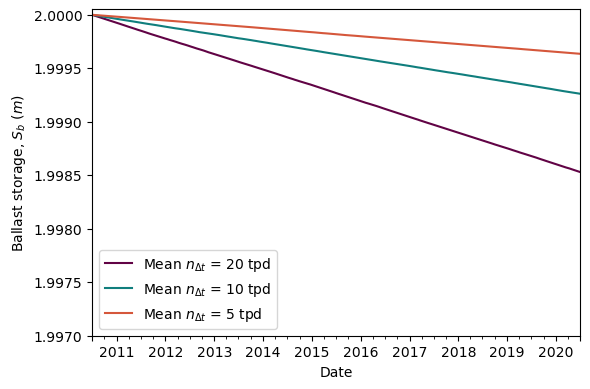

In [13]:
fig5, ax5 = plt.subplots(figsize=(6,4))
storms_df.plot(y='S_b_20', ax=ax5, color = '#610345', label=r'Mean $n_{\Delta t}$ = 20 tpd')
storms_df.plot(y='S_b_10', ax=ax5, color = '#107E7D', label=r'Mean $n_{\Delta t}$ = 10 tpd')
storms_df.plot(y='S_b_5', ax=ax5, color = '#D5573B', label=r'Mean $n_{\Delta t}$ = 5 tpd')

ax5.set_ylim(1.997, 2.00005)
ax5.tick_params(axis='x', labelrotation=0)
for label in ax5.get_xticklabels():
    label.set_horizontalalignment('center')
ax5.legend()
plt.xlabel('Date')
plt.ylabel(r'Ballast storage, $S_b$ $(m)$')
plt.tight_layout()
plt.show()

### Sediment load per meter of road for each water year

This is the main goal of the model. The sediment load per meter of road for each year can be compared to data collected in the field, with the understanding that this model likely overestimates the sediment load because: (1) our parameters are currently only estimates and (2) the spatially lumped model includes only the road prism, whereas data collected in the field typically includes roadside ditch lines, which tend to have grass linings serving as an erosion control treatment for sediment-laden water entering the ditches.

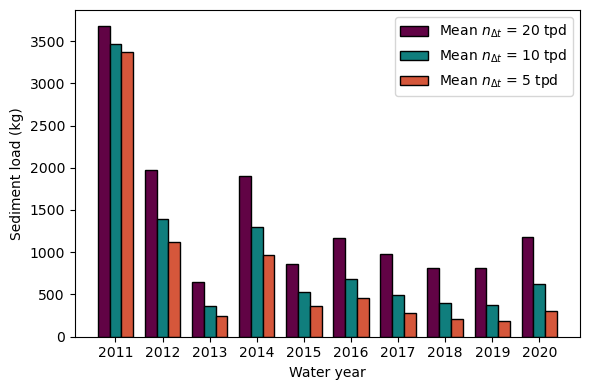

In [14]:
#Subset data by water year
years=storms_df.groupby(storms_df.index.year).count().index.to_numpy()
yr_5 = np.zeros(len(years)-1)
yr_10 = np.zeros(len(years)-1)
yr_20 = np.zeros(len(years)-1)
for i, year in enumerate(years):
    if i < len(years)-1:
        yr_5[i] = (storms_df.Hs_out_5[str(year)+'-07-01':str(year+1)+'-06-30'].sum())/1000
        yr_10[i] = (storms_df.Hs_out_10[str(year)+'-07-01':str(year+1)+'-06-30'].sum())/1000
        yr_20[i] = (storms_df.Hs_out_20[str(year)+'-07-01':str(year+1)+'-06-30'].sum())/1000

#Multiply Hs_out
sed_area_5 = yr_5*L*80
sed_load_5 = sed_area_5*rho_s

sed_area_10 = yr_10*L*80
sed_load_10 = sed_area_10*rho_s

sed_area_20 = yr_20*L*80
sed_load_20 = sed_area_20*rho_s

width = 0.25

ticks = years[1:len(years)]
fig6, ax6 = plt.subplots(figsize=(6,4))
plt.bar(years[1:len(years)]-width, sed_load_20, width, color = '#610345', edgecolor='k', label=r'Mean $n_{\Delta t}$ = 20 tpd')
plt.bar(years[1:len(years)], sed_load_10, width, color = '#107E7D', edgecolor='k', label=r'Mean $n_{\Delta t}$ = 10 tpd')
plt.bar(years[1:len(years)]+width, sed_load_5, width, color = '#D5573B', edgecolor='k', label=r'Mean $n_{\Delta t}$ = 5 tpd')
plt.xlabel('Water year')
plt.ylabel(r'Sediment load (kg)')
plt.legend()
plt.xticks(range(ticks[0],ticks[len(ticks)-1]+1), ticks, rotation=0)
plt.tight_layout()
plt.show()

As a final sanity check, we can make sure that the sediment mass balance is ok.

In [15]:
sed_sum_m_5 = storms_df.sed_added_5.sum()-(storms_df.Hs_out_5.sum()/1000)
sed_sum_kg_m_5 = sed_sum_m_5*rho_s*L
f = ((storms_df.S_f_5.iloc[len(storms_df)-1]-storms_df.S_f_5.iloc[0])/1000)*rho_s*L

if round(f) == round(sed_sum_kg_m_5):
    print('\nThe mass balance is fine.')
else:
    print('\nThe mass balance is off.')


The mass balance is fine.
